In [1]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr

In [2]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for iid, _ in user_ratings[:n]]

    return top_n

In [3]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

train_df, test_df = train_test_split(data_df, test_size=0.2)
U = sorted(train_df["user_id"].unique())

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_df.to_records(index=False)]
raw_testset = [(ruid, riid, r, None) for ruid, riid, r in test_df.to_records(index=False)]
trainset = Dataset.construct_trainset(dataset, raw_trainset)
testset = Dataset.construct_testset(dataset, raw_testset)

# KNN similarity

In [4]:
BEST_K = 7

In [5]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [24]:
from numba import jit
from datetime import datetime as dt
@jit(nopython=True, parallel=True)
#@jit(nopython=True)
def f(t):
    for i in range(t): pass

start = dt.now()
f(10**8)
str(dt.now() - start)

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\numba\core\typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-24-a80d9d7fc46a>", line 5:
#@jit(nopython=True)
def f(t):
^

  state.func_ir.loc))


'0:00:00.094334'

In [6]:
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    model_without_u = UserKNN(k=BEST_K, precomputed_sim=sim)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("[%f%% Done] Time elapsed %s, Influence %f" % (100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid]))
    
    i += 1

[0.106045% Done] Time elapsed 0:00:05.397849, Influence 0.301639
[0.212089% Done] Time elapsed 0:00:11.407659, Influence 0.301832
[0.318134% Done] Time elapsed 0:00:17.160867, Influence 0.300815
[0.424178% Done] Time elapsed 0:00:21.666067, Influence 0.301101
[0.530223% Done] Time elapsed 0:00:26.460864, Influence 0.301101
[0.636267% Done] Time elapsed 0:00:31.261700, Influence 0.301427
[0.742312% Done] Time elapsed 0:00:36.439678, Influence 0.301018
[0.848356% Done] Time elapsed 0:00:42.151868, Influence 0.301208
[0.954401% Done] Time elapsed 0:00:46.697871, Influence 0.300529
[1.060445% Done] Time elapsed 0:00:51.502703, Influence 0.300766


KeyboardInterrupt: 

Text(0.5, 1.0, 'Spearman Rank Correlation 0.0322 (p-value: 0.32)')

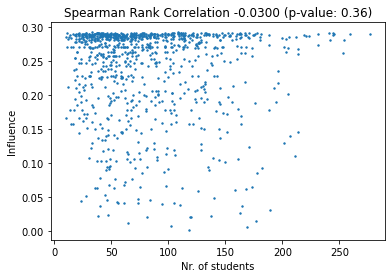

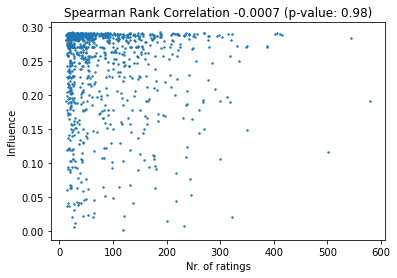

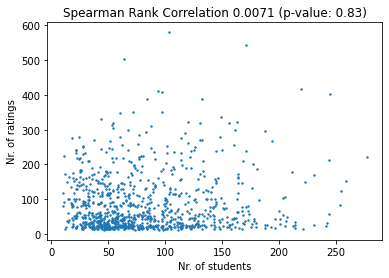

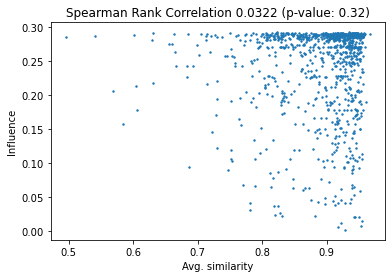

In [44]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

r, p = spearmanr(n_students, n_ratings)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

In [45]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.2843, All mentors: 0.2391
[Avg. Degree] Highest influential mentors: 91.0000, All mentors: 81.3256


# KNN similarity, reuse

In [46]:
BEST_K = 7

In [47]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim, reuse=True)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [68]:
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    model_without_u = UserKNN(k=BEST_K, precomputed_sim=sim, reuse=True)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("[%f%% Done] Time elapsed %s, Influence %f" % (100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid]))
    
    i += 1

[0.106045% Done] Time elapsed 0:00:05.093502, Influence 0.287526
[0.212089% Done] Time elapsed 0:00:10.444503, Influence 0.288056
[0.318134% Done] Time elapsed 0:00:15.431600, Influence 0.288598
[0.424178% Done] Time elapsed 0:00:20.877355, Influence 0.288399
[0.530223% Done] Time elapsed 0:00:26.534500, Influence 0.288001
[0.636267% Done] Time elapsed 0:00:31.663484, Influence 0.288058
[0.742312% Done] Time elapsed 0:00:37.023496, Influence 0.288204
[0.848356% Done] Time elapsed 0:00:41.815700, Influence 0.288008
[0.954401% Done] Time elapsed 0:00:46.579885, Influence 0.288711
[1.060445% Done] Time elapsed 0:00:52.233462, Influence 0.287743
[1.166490% Done] Time elapsed 0:00:57.946616, Influence 0.287367
[1.272534% Done] Time elapsed 0:01:03.360500, Influence 0.286795
[1.378579% Done] Time elapsed 0:01:08.198426, Influence 0.285083
[1.484624% Done] Time elapsed 0:01:13.089391, Influence 0.285103
[1.590668% Done] Time elapsed 0:01:18.239912, Influence 0.284744
[1.696713% Done] Time ela

[13.467656% Done] Time elapsed 0:11:11.386432, Influence 0.284347
[13.573701% Done] Time elapsed 0:11:18.598883, Influence 0.284331
[13.679745% Done] Time elapsed 0:11:24.365230, Influence 0.283942
[13.785790% Done] Time elapsed 0:11:29.931020, Influence 0.284002
[13.891835% Done] Time elapsed 0:11:36.236128, Influence 0.284623
[13.997879% Done] Time elapsed 0:11:42.010210, Influence 0.285109
[14.103924% Done] Time elapsed 0:11:47.813545, Influence 0.285228
[14.209968% Done] Time elapsed 0:11:52.578762, Influence 0.284378
[14.316013% Done] Time elapsed 0:11:57.620192, Influence 0.284025
[14.422057% Done] Time elapsed 0:12:02.847082, Influence 0.284152
[14.528102% Done] Time elapsed 0:12:08.360676, Influence 0.284016
[14.634146% Done] Time elapsed 0:12:14.398856, Influence 0.283813
[14.740191% Done] Time elapsed 0:12:20.585908, Influence 0.283928
[14.846235% Done] Time elapsed 0:12:26.143086, Influence 0.283434
[14.952280% Done] Time elapsed 0:12:31.619129, Influence 0.283819
[15.058324

[26.723224% Done] Time elapsed 0:23:02.658162, Influence 0.278093
[26.829268% Done] Time elapsed 0:23:08.829206, Influence 0.279421
[26.935313% Done] Time elapsed 0:23:15.199034, Influence 0.278798
[27.041357% Done] Time elapsed 0:23:22.086578, Influence 0.278871
[27.147402% Done] Time elapsed 0:23:28.986667, Influence 0.277150
[27.253446% Done] Time elapsed 0:23:34.214048, Influence 0.276971
[27.359491% Done] Time elapsed 0:23:39.446963, Influence 0.277207
[27.465536% Done] Time elapsed 0:23:44.940035, Influence 0.277314
[27.571580% Done] Time elapsed 0:23:50.854945, Influence 0.277203
[27.677625% Done] Time elapsed 0:23:56.842190, Influence 0.276807
[27.783669% Done] Time elapsed 0:24:01.849350, Influence 0.277024
[27.889714% Done] Time elapsed 0:24:06.981145, Influence 0.277308
[27.995758% Done] Time elapsed 0:24:13.732377, Influence 0.277752
[28.101803% Done] Time elapsed 0:24:21.102545, Influence 0.277630
[28.207847% Done] Time elapsed 0:24:27.336626, Influence 0.277109
[28.313892

[39.978791% Done] Time elapsed 0:35:29.805793, Influence 0.272050
[40.084836% Done] Time elapsed 0:35:36.244064, Influence 0.272503
[40.190880% Done] Time elapsed 0:35:41.236800, Influence 0.272222
[40.296925% Done] Time elapsed 0:35:46.515844, Influence 0.272088
[40.402969% Done] Time elapsed 0:35:51.787796, Influence 0.271552
[40.509014% Done] Time elapsed 0:35:57.588915, Influence 0.270905
[40.615058% Done] Time elapsed 0:36:04.077878, Influence 0.270952
[40.721103% Done] Time elapsed 0:36:09.576837, Influence 0.270671
[40.827147% Done] Time elapsed 0:36:14.489862, Influence 0.270383
[40.933192% Done] Time elapsed 0:36:19.605920, Influence 0.268395
[41.039236% Done] Time elapsed 0:36:25.004868, Influence 0.268666
[41.145281% Done] Time elapsed 0:36:31.552952, Influence 0.268122
[41.251326% Done] Time elapsed 0:36:37.683139, Influence 0.267772
[41.357370% Done] Time elapsed 0:36:43.179447, Influence 0.268125
[41.463415% Done] Time elapsed 0:36:48.822784, Influence 0.268482
[41.569459

[53.234358% Done] Time elapsed 0:47:11.798663, Influence 0.251288
[53.340403% Done] Time elapsed 0:47:16.614084, Influence 0.251566
[53.446448% Done] Time elapsed 0:47:21.558930, Influence 0.251080
[53.552492% Done] Time elapsed 0:47:26.643009, Influence 0.251131
[53.658537% Done] Time elapsed 0:47:31.993313, Influence 0.250824
[53.764581% Done] Time elapsed 0:47:37.828219, Influence 0.249603
[53.870626% Done] Time elapsed 0:47:50.138192, Influence 0.249685
[53.976670% Done] Time elapsed 0:48:03.370886, Influence 0.249290
[54.082715% Done] Time elapsed 0:48:15.818293, Influence 0.248832
[54.188759% Done] Time elapsed 0:48:28.773501, Influence 0.249166
[54.294804% Done] Time elapsed 0:48:37.140356, Influence 0.248735
[54.400848% Done] Time elapsed 0:48:41.596713, Influence 0.248893
[54.506893% Done] Time elapsed 0:48:46.286966, Influence 0.248866
[54.612937% Done] Time elapsed 0:48:50.913126, Influence 0.248987
[54.718982% Done] Time elapsed 0:48:55.857720, Influence 0.249044
[54.825027

[66.489926% Done] Time elapsed 0:58:10.834441, Influence 0.223156
[66.595970% Done] Time elapsed 0:58:16.106042, Influence 0.221231
[66.702015% Done] Time elapsed 0:58:21.175804, Influence 0.220803
[66.808059% Done] Time elapsed 0:58:26.074259, Influence 0.221283
[66.914104% Done] Time elapsed 0:58:30.699522, Influence 0.220366
[67.020148% Done] Time elapsed 0:58:35.525494, Influence 0.217772
[67.126193% Done] Time elapsed 0:58:40.525000, Influence 0.218086
[67.232238% Done] Time elapsed 0:58:45.705540, Influence 0.217425
[67.338282% Done] Time elapsed 0:58:50.538780, Influence 0.217127
[67.444327% Done] Time elapsed 0:58:55.206516, Influence 0.216316
[67.550371% Done] Time elapsed 0:59:00.115710, Influence 0.216100
[67.656416% Done] Time elapsed 0:59:05.197026, Influence 0.215184
[67.762460% Done] Time elapsed 0:59:10.520411, Influence 0.215478
[67.868505% Done] Time elapsed 0:59:15.913639, Influence 0.214793
[67.974549% Done] Time elapsed 0:59:21.163452, Influence 0.214347
[68.080594

[79.745493% Done] Time elapsed 1:08:43.675880, Influence 0.174419
[79.851538% Done] Time elapsed 1:08:49.297207, Influence 0.173258
[79.957582% Done] Time elapsed 1:08:56.265393, Influence 0.173278
[80.063627% Done] Time elapsed 1:09:02.036243, Influence 0.172787
[80.169671% Done] Time elapsed 1:09:07.162221, Influence 0.172328
[80.275716% Done] Time elapsed 1:09:12.510988, Influence 0.172367
[80.381760% Done] Time elapsed 1:09:17.904658, Influence 0.172277
[80.487805% Done] Time elapsed 1:09:22.746548, Influence 0.171414
[80.593849% Done] Time elapsed 1:09:27.783620, Influence 0.171474
[80.699894% Done] Time elapsed 1:09:32.997655, Influence 0.171455
[80.805938% Done] Time elapsed 1:09:38.379557, Influence 0.171574
[80.911983% Done] Time elapsed 1:09:43.375565, Influence 0.170053
[81.018028% Done] Time elapsed 1:09:48.408714, Influence 0.168361
[81.124072% Done] Time elapsed 1:09:53.205516, Influence 0.167885
[81.230117% Done] Time elapsed 1:09:58.271549, Influence 0.167211
[81.336161

[93.001060% Done] Time elapsed 1:22:34.074566, Influence 0.086563
[93.107105% Done] Time elapsed 1:22:41.046273, Influence 0.086305
[93.213150% Done] Time elapsed 1:22:47.801268, Influence 0.085003
[93.319194% Done] Time elapsed 1:22:54.206590, Influence 0.084422
[93.425239% Done] Time elapsed 1:23:01.094108, Influence 0.084777
[93.531283% Done] Time elapsed 1:23:08.638080, Influence 0.084286
[93.637328% Done] Time elapsed 1:23:15.431606, Influence 0.083988
[93.743372% Done] Time elapsed 1:23:22.761226, Influence 0.083944
[93.849417% Done] Time elapsed 1:23:31.041747, Influence 0.077712
[93.955461% Done] Time elapsed 1:23:37.253608, Influence 0.077390
[94.061506% Done] Time elapsed 1:23:43.891904, Influence 0.077486
[94.167550% Done] Time elapsed 1:23:50.738302, Influence 0.077551
[94.273595% Done] Time elapsed 1:24:00.435446, Influence 0.077293
[94.379639% Done] Time elapsed 1:24:07.368962, Influence 0.076423
[94.485684% Done] Time elapsed 1:24:16.760348, Influence 0.075649
[94.591729

Text(0.5, 1.0, 'Spearman Rank Correlation 0.0297 (p-value: 0.36)')

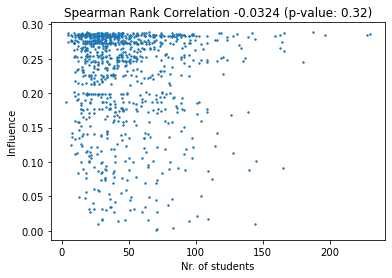

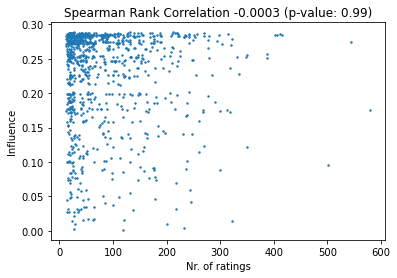

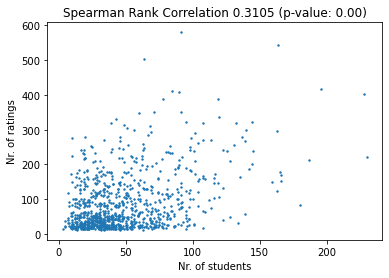

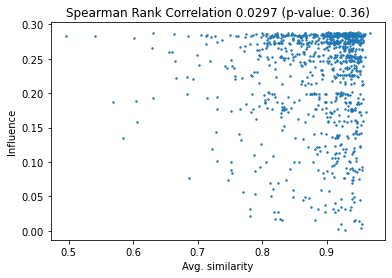

In [69]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

r, p = spearmanr(n_students, n_ratings)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

In [70]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.2570, All mentors: 0.2247
[Avg. Degree] Highest influential mentors: 69.0000, All mentors: 47.3860


In [90]:
sum(influence)

211.89534293279922

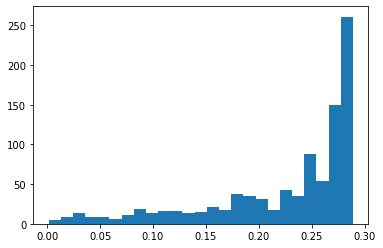

In [81]:
plt.hist(influence, bins=25);

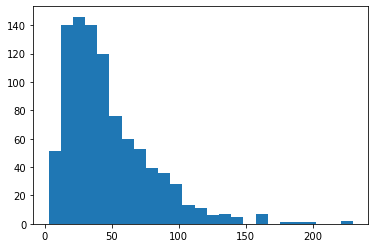

In [83]:
plt.hist(n_students, bins=25);

In [93]:
top_influencers = np.argsort(n_students)[-10:]
top_influencers_df = train_df[train_df["user_id"].isin(top_influencers)]
top_influencers_df.groupby("user_id").size().mean(), train_df.groupby("user_id").size().mean()

(141.6, 84.83457051961824)

In [92]:
top_mentors = np.argsort(n_students)[-10:]
np.mean(avg_similarity[top_mentors]), np.mean(avg_similarity)

(0.9343636968887774, 0.8879353047062929)